In [ ]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Receiving objects: 100% (24/24), 6.34 MiB | 19.86 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [62]:
import matplotlib.pyplot as plt

In [63]:
#from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)])

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [ ]:
X_train, y_train = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Train 60000.cdb')
X_test, y_test = read_hoda_dataset('/content/HodaDatasetReader/DigitDB/Test 20000.cdb')

In [ ]:
X_train.shape

In [67]:
y_train.shape

(60000,)

In [82]:
y_train

array([6., 5., 0., ..., 2., 6., 6.], dtype=float32)

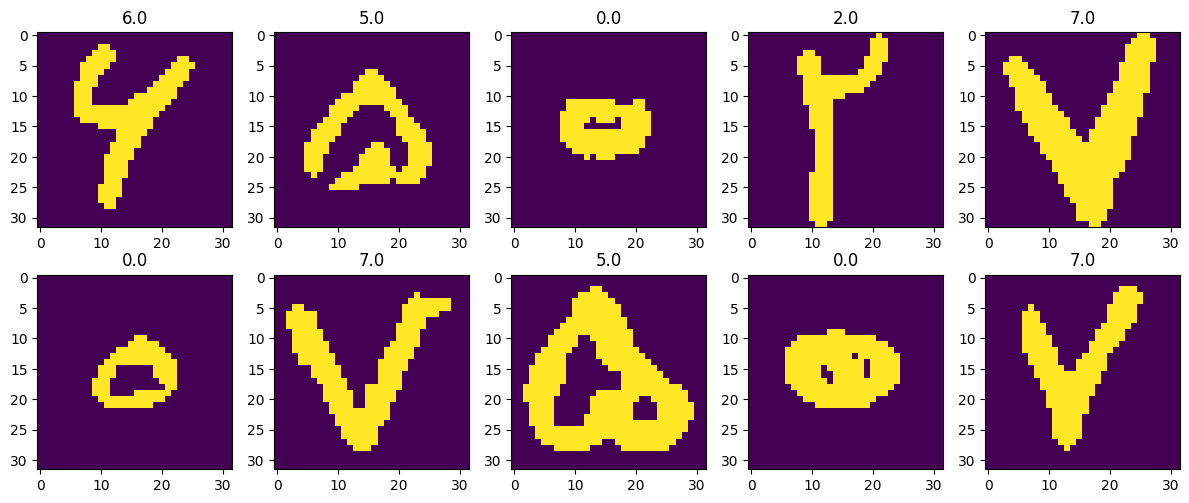

In [83]:
plt.figure(figsize=(12,5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_train[i].reshape(32,32))
  plt.title(y_train[i])

plt.tight_layout()
plt.show()

In [84]:
#one-hot encoding
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [70]:
##Import the libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers, regularizers

In [85]:
# Building the neural network
##define input layer
input_layer = Input(shape=(1024,), name='input_layer')
initializer = initializers.HeUniform()

##Defining 3 hidden layers
Layer_1 = Dense(512, activation="relu", name='Layer_1', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(1e-3))(input_layer)
Layer_2 = Dropout(0.5)(Layer_1)

Layer_3 = Dense(256, activation="relu", name='Layer_3', kernel_regularizer=regularizers.l2(1e-3))(Layer_2)
Layer_4 = Dropout(0.5)(Layer_3)

Layer_5 = Dense(128, activation='relu', kernel_regularizer='l2', name='Layer_5')(Layer_4)

##overfitting handling
Layer_6 = BatchNormalization()(Layer_5)
Layer_7 = Dropout(0.5)(Layer_6)

##Defining output layer
output = Dense(10, activation="softmax", name='output')(Layer_7)

##Defining the model by specifying the input and output layers
model = Model(inputs=input_layer, outputs=output)

In [86]:
##summary of the model
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1024)]            0         
                                                                 
 Layer_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_45 (Dropout)        (None, 512)               0         
                                                                 
 Layer_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 Layer_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_15 (Ba  (None, 128)               512

In [87]:
## defining the optimiser and loss function
from keras.optimizers import Adam
#from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score

adam = Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.998)
#scce = SparseCategoricalCrossentropy()
#metric = F1Score()

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

##training the model
history = model.fit(X_train, y_train, epochs=100, verbose=True,
                    batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
469/469 [==============================] - 5s 7ms/step - loss: 1.9791 - accuracy: 0.8758 - val_loss: 0.9054 - val_accuracy: 0.9446
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6382 - accuracy: 0.9578 - val_loss: 0.4942 - val_accuracy: 0.9559
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4161 - accuracy: 0.9643 - val_loss: 0.4028 - val_accuracy: 0.9550
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3534 - accuracy: 0.9665 - val_loss: 0.3733 - val_accuracy: 0.9542
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3271 - accuracy: 0.9666 - val_loss: 0.3366 - val_accuracy: 0.9620
Epoch 6/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3195 - accuracy: 0.9669 - val_loss: 0.3256 - val_accuracy: 0.9633
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.3127 - accuracy: 0.9680 - val_loss: 0.3152 - val_accuracy: 0.9657

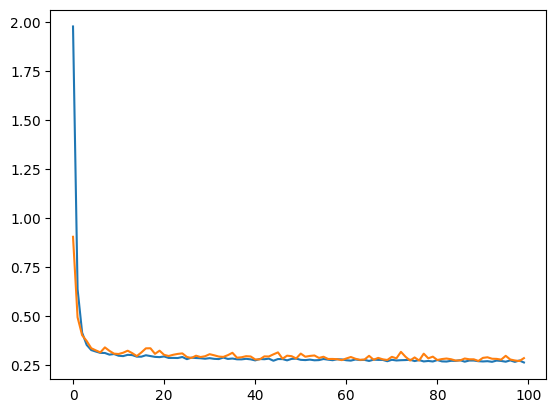

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [89]:
score = model.evaluate(X_test, y_test)
print("test loss: ",  score[0])
print("test accuracy: ",  score[1])

625/625 [==============================] - 2s 3ms/step - loss: 0.2859 - accuracy: 0.9641
test loss:  0.2858700752258301
test accuracy:  0.9641000032424927
